In [ ]:
#imports
import numpy as np
import pandas as pd
import lightgbm as lgb


In [24]:
# Get data
df = pd.read_csv('fraud_email_preprocessed.csv')
df


,Text,Class
0,supply quality china s exclusive dimensions at...,1
1,over sidlet me know thx,0
2,dear friend greetings to you i wish to accost ...,1
3,mr cheung puihang seng bank ltd des voeux rd ...,1
4,not a surprising assessment from embassy,0
...,...,...
10244,i called and was transferred to room but got n...,0
10245,travel well i ll look forward to hearing your...,0
10246,follow up flag follow upflag status flaggedm...,0
10247,sbwhoeop bnumbersaturday january number number...,0


In [25]:
df_final = df['Text']
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

bow = []
for message in df_final:
    words = word_tokenize(message)
    for w in words:
        bow.append(w)

[nltk_data] Downloading package punkt to /Users/Lidia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
# handle TF|IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(df_final)
tfidf_data=pd.DataFrame(tfidf_vec.toarray())

print(tfidf_data.size)

841893856


In [27]:
from sklearn.decomposition import TruncatedSVD 

svd = TruncatedSVD(n_components=350, algorithm='randomized')
df_svd = svd.fit_transform(tfidf_data)

In [28]:
df_new = pd.DataFrame(df_svd)

df_train = df_new.iloc[:4457]
df_test = df_new.iloc[4457:]

target = df['Class']
df_train['Class'] = target

Y = df_train['Class']
X = df_train.drop('Class',axis=1)

/var/folders/b3/6j7dyswj5tg9ztf70f_5v8l00000gn/T/ipykernel_71491/3725565269.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Class'] = target


In [30]:
# Splitting the data into train and test
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.35, random_state=42)

In [31]:
# Predicting and calculating f1 score
from sklearn.metrics import f1_score

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f2 = round(f1_score(pred, y_test),3)
    print(f'F1 score is: ',f2)
    
for depth in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19):
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200,alpha=0.1,num_leaves=74)
    print(f"Max Depth {depth}")
    train_and_test(lgbmodel, "Light GBM")
    print("____________________________________")

Max Depth 1
F1 score is:  0.946
____________________________________
Max Depth 2
F1 score is:  0.975
____________________________________
Max Depth 3
F1 score is:  0.975
____________________________________
Max Depth 4
F1 score is:  0.975
____________________________________
Max Depth 5
F1 score is:  0.978
____________________________________
Max Depth 6
F1 score is:  0.978
____________________________________
Max Depth 7
F1 score is:  0.977
____________________________________
Max Depth 8
F1 score is:  0.979
____________________________________
Max Depth 9
F1 score is:  0.979
____________________________________
Max Depth 10
F1 score is:  0.978
____________________________________
Max Depth 11
F1 score is:  0.978
____________________________________
Max Depth 12
F1 score is:  0.976
____________________________________
Max Depth 13
F1 score is:  0.979
____________________________________
Max Depth 14
F1 score is:  0.978
____________________________________
Max Depth 15
F1 score is:  0.

In [32]:
# Using this class to make my print statement look bold
class color:
    BOLD = '\033[1m'

In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

y_pred=lgbmodel.predict(X_test)
print(color.BOLD +'Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('-----------------------------------------------------------------------')
print(color.BOLD +'Accuracy Score:', accuracy_score(y_test,y_pred))
print('-----------------------------------------------------------------------')

#Predicting and calculating f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_pred, y_test)
f1_round = round(f1,3)

print(color.BOLD + 'F1 score:',f1_round)
print('-----------------------------------------------------------------------')
print('Classification Report:')
print(color.BOLD +'\n',classification_report(y_test,y_pred))
print('-----------------------------------------------------------------------')

Confusion Matrix:
 [[873   5]
 [ 24 658]]
-----------------------------------------------------------------------
Accuracy Score: 0.9814102564102564
-----------------------------------------------------------------------
F1 score: 0.978
-----------------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       878
           1       0.99      0.96      0.98       682

    accuracy                           0.98      1560
   macro avg       0.98      0.98      0.98      1560
weighted avg       0.98      0.98      0.98      1560

-----------------------------------------------------------------------


In [34]:
print('Training Accuracy : %.3f' %lgbmodel.score(X_train, y_train))
print('Test Accuracy : %.3f' %lgbmodel.score(X_test, y_test))

Training Accuracy : 0.999
Test Accuracy : 0.981


In [36]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc score
auc_score = roc_auc_score(y_test, y_pred)

print(auc_score)

0.9795573116720886


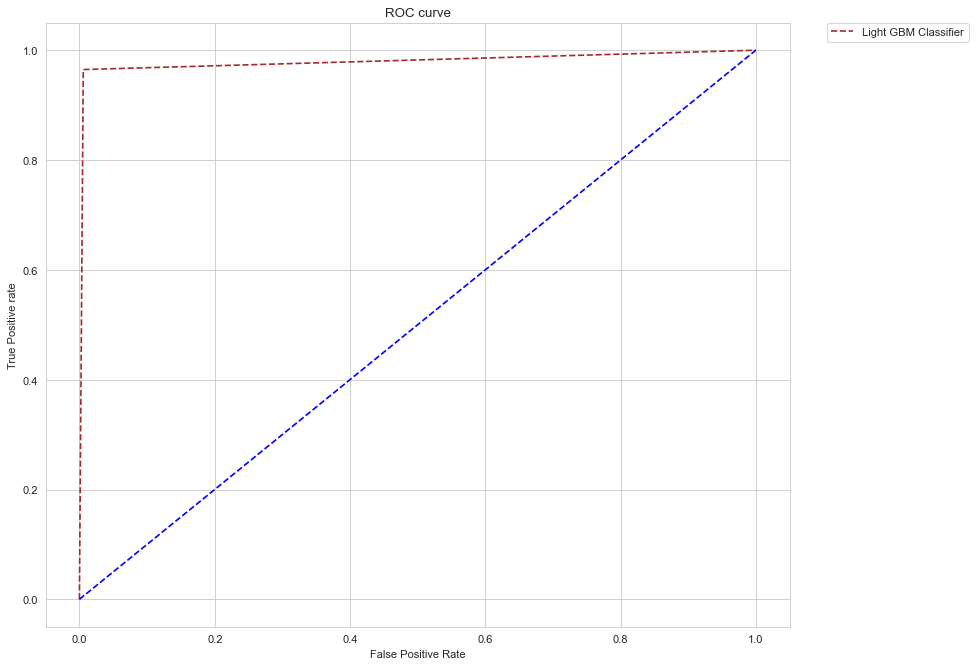

In [39]:
import seaborn as sns
sns.set_style("whitegrid")

# Changing image size
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(12, 10), dpi=80)

# Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='brown', label='Light GBM Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Title
plt.title('ROC curve')

# X-label
plt.xlabel('False Positive Rate')

# Y-label
plt.ylabel('True Positive rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()